# YOLO Boat Detection: Training Notebook

This notebook demonstrates how to train a YOLO model to detect the direction of boats in open water using a preprocessed dataset (auto-orient, resize 640x640, random noise, and rotations) located in `/dataset`.

**Outline:**
1. Import Required Libraries
2. Load and Inspect the Dataset
3. Prepare YOLO-Compatible Dataset Structure
4. Configure YOLO Model and Training Parameters
5. Train the YOLO Model
6. Visualize Training Metrics
7. Evaluate Model Performance on Validation Data
8. Run Inference on Sample Images

In [1]:
# 1. Import Required Libraries
import os
import random
import torch
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO

## 2. Load and Inspect the Dataset

Let's visualize a few random images and their labels to verify preprocessing and augmentation. 

**Dataset details:**
- Exported from Roboflow (Feb 18, 2026)
- 871 images, YOLOv11 format
- Preprocessing: auto-orientation, resize to 640x640 (stretch)
- Augmentation: random rotation (-5° to +5°), salt & pepper noise (0.14% pixels), 3 versions per image
- Already split into train, valid, and test sets

For more info and state-of-the-art notebooks, see: https://github.com/roboflow/notebooks

Image: IM_03184_JPG.rf.042a0f595f3b5207e2438e6875aa9b56.jpg


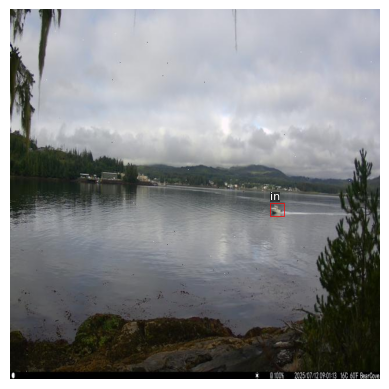

Image: IM_02020_JPG.rf.76f836e8676baebe628f8ee6631d8fdb.jpg


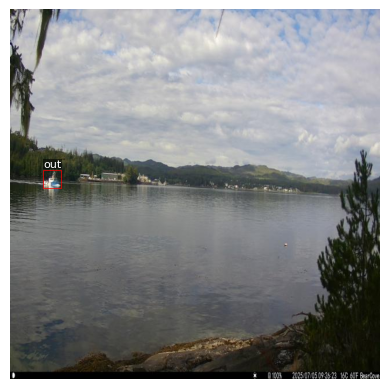

Image: IM_03551_JPG.rf.8ca6b519d937d5981fe2efd7d7f16ce6.jpg


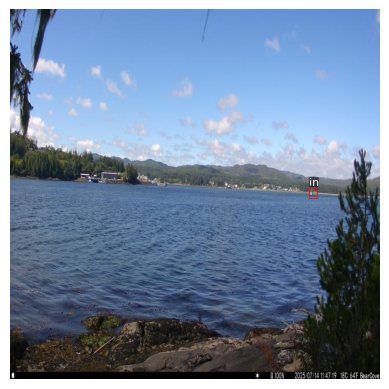

In [2]:
# Visualize random images and their YOLO labels, with class name (in/out)
def plot_yolo_labels(img_path, label_path):
    class_names = ['in', 'out'] 
    img = Image.open(img_path)
    w, h = img.size
    boxes = []
    labels = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                cls, x, y, bw, bh = map(float, line.strip().split())
                # Convert YOLO format to box coordinates
                x1 = (x - bw/2) * w
                y1 = (y - bh/2) * h
                x2 = (x + bw/2) * w
                y2 = (y + bh/2) * h
                boxes.append((x1, y1, x2, y2))
                labels.append(int(cls))
    plt.imshow(img)
    ax = plt.gca()
    for box, cls in zip(boxes, labels):
        rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False, color='red', linewidth=0.5)
        ax.add_patch(rect)
        # Add class name label above the box
        ax.text(box[0], box[1] - 2, class_names[cls], color='white', fontsize=8, va='bottom', ha='left', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', pad=0))
    plt.axis('off')
    plt.show()


    
img_dir = "img\\chokepoint v3\\train\\images"
label_dir = "img\\chokepoint v3\\train\\labels"
img_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))]
for i in range(3):
    img_file = random.choice(img_files)
    label_file = os.path.splitext(img_file)[0] + '.txt'
    print(f"Image: {img_file}")
    plot_yolo_labels(os.path.join(img_dir, img_file), os.path.join(label_dir, label_file))

## 3. Prepare YOLO-Compatible Dataset Structure

Ensure the dataset is in YOLO format:
- `/dataset/images/train`, `/dataset/images/val`, `/dataset/images/test`
- `/dataset/labels/train`, `/dataset/labels/val`, `/dataset/labels/test`

If not, split and organize the dataset accordingly.

In [3]:
# Printing number of images in train/test/valid splits - sanity check
splits = ['train', 'valid', 'test']
for split in splits:
    img_dir = os.path.join('img', 'chokepoint v3', split, 'images')
    label_dir = os.path.join('img', 'chokepoint v3', split, 'labels')
    num_imgs = len([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))])
    num_labels = len([f for f in os.listdir(label_dir) if f.endswith('.txt')])
    print(f"{split.capitalize()} - Images: {num_imgs}, Labels: {num_labels}")

Train - Images: 708, Labels: 708
Valid - Images: 114, Labels: 114
Test - Images: 49, Labels: 49


## 4. Configure YOLO Model and Training Parameters

Set up the YOLO model, number of classes, and training configuration.

In [4]:
# Define YOLO config YAML for custom dataset
yolo_yaml = '''
path: ./img/chokepoint v3
train: train/images
val: valid/images
nc: 2
names: ['in','out']
'''
with open('chokepoint.yaml', 'w') as f:
    f.write(yolo_yaml)

# Choose YOLO model - v8n is small/fast, v8m/v8l for more accuracy
model = YOLO('yolov8n.pt')  

## 5. Train the YOLO Model

Train the model using the custom dataset and configuration.

In [5]:
import torch
torch.set_num_threads(4)

results = model.train(
    data='chokepoint.yaml',
    epochs=50,
    imgsz=320,
    batch=4,
    lr0=0.002,
    lrf=0.01,
    patience=10,
    project='chokepoint',
    exist_ok=True,
    device='cpu'
)


New https://pypi.org/project/ultralytics/8.4.14 available  Update with 'pip install -U ultralytics'
Ultralytics 8.4.9  Python-3.11.14 torch-2.10.0+cpu CPU (Intel Core i7-6600U 2.60GHz)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=chokepoint.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.002, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, op

In [6]:
model_trained = YOLO('runs/detect/chokepoint/train/weights/best.pt')  
fine_tuned = model_trained.train(
                data='chokepoint.yaml',
                project = 'chokepoint_finetuned',
                epochs=20,
                patience=5,
                imgsz=416,
                batch=4,
                exist_ok=True,
                device='cpu'
            )

New https://pypi.org/project/ultralytics/8.4.14 available  Update with 'pip install -U ultralytics'
Ultralytics 8.4.9  Python-3.11.14 torch-2.10.0+cpu CPU (Intel Core i7-6600U 2.60GHz)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=chokepoint.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs/detect/chokepoint/train/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, 

## 6. Visualize Training Metrics

Plot training and validation loss, mAP, and other metrics to monitor model performance.

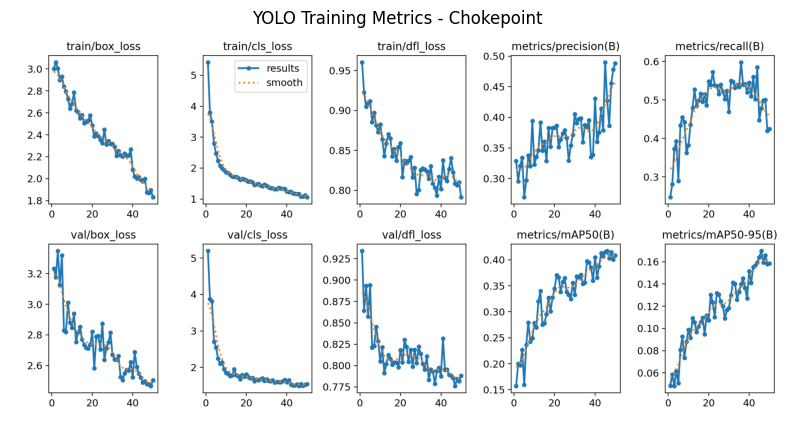

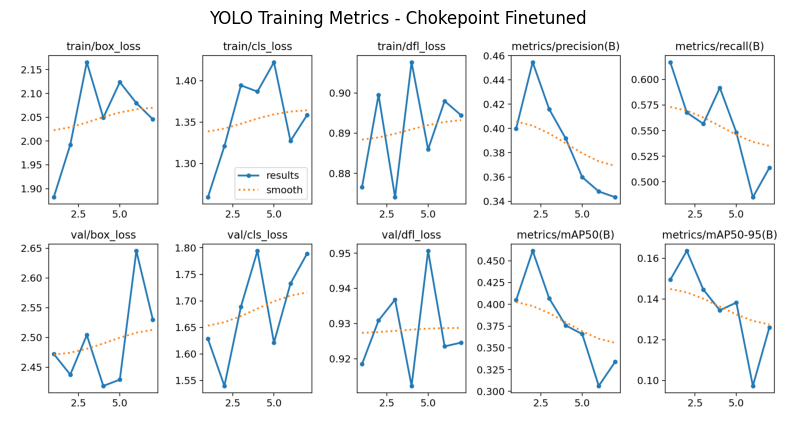

In [7]:
# Plot training results (loss, mAP, etc.)
results_path = 'runs\\detect\\chokepoint\\train\\results.png'
if os.path.exists(results_path):
    img = Image.open(results_path)
    plt.figure(figsize=(10,6))
    plt.imshow(img)
    plt.axis('off')
    plt.title('YOLO Training Metrics - Chokepoint')
    plt.show()
else:
    print('Training results plot not found.')

results_path = 'runs\\detect\\chokepoint_finetuned\\train\\results.png'
if os.path.exists(results_path):
    img = Image.open(results_path)
    plt.figure(figsize=(10,6))
    plt.imshow(img)
    plt.axis('off')
    plt.title('YOLO Training Metrics - Chokepoint Finetuned')
    plt.show()
else:
    print('Training results plot not found.')

## 7. Evaluate Model Performance on Validation Data

Evaluate the trained model on the validation set and display metrics and example predictions.

In [8]:
# Evaluate on validation set 
# P = precision, R = recall, mAP = mean average precision
metrics = model_trained.val(data='chokepoint.yaml', split='val', name='val', exist_ok=True)  

Ultralytics 8.4.9  Python-3.11.14 torch-2.10.0+cpu CPU (Intel Core i7-6600U 2.60GHz)
Model summary (fused): 73 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 248.873.5 MB/s, size: 47.4 KB)
val: Scanning C:\Users\hp\Desktop\PSF\camera_fishing_effort\notebooks\img\chokepoint v3\valid\labels.cache... 114 images, 11 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 114/114 113.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 2.7s/it 21.4s3.4ss
                   all        114        135      0.448      0.598      0.464      0.164
                    in         61         71      0.459      0.634      0.522        0.2
                   out         53         64      0.438      0.562      0.407      0.129
Speed: 1.7ms preprocess, 161.6ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to C:\Users\hp\Desktop\PSF\camera_fishing_effort\notebooks\runs\detec


image 1/1 c:\Users\hp\Desktop\PSF\camera_fishing_effort\notebooks\img\chokepoint v3\valid\images\IM_05689_JPG.rf.e876852a69fffe0245a6439e90d85f88.jpg: 416x416 1 out, 234.3ms
Speed: 5.8ms preprocess, 234.3ms inference, 10.0ms postprocess per image at shape (1, 3, 416, 416)


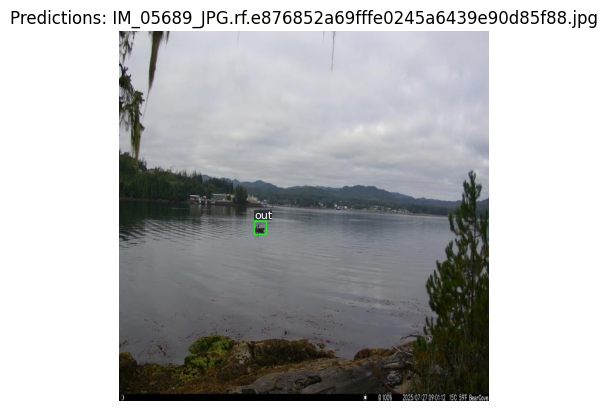


image 1/1 c:\Users\hp\Desktop\PSF\camera_fishing_effort\notebooks\img\chokepoint v3\valid\images\IM_04591_JPG.rf.c64f9ac7dd2e2a36235f8fafc4eea456.jpg: 416x416 1 in, 193.0ms
Speed: 4.0ms preprocess, 193.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)


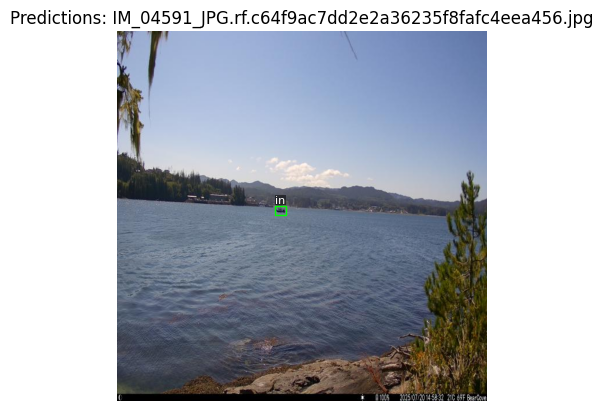


image 1/1 c:\Users\hp\Desktop\PSF\camera_fishing_effort\notebooks\img\chokepoint v3\valid\images\IM_03496_JPG.rf.a2bee64fe8d5015f4a34b56242e64835.jpg: 416x416 1 out, 168.4ms
Speed: 7.9ms preprocess, 168.4ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)


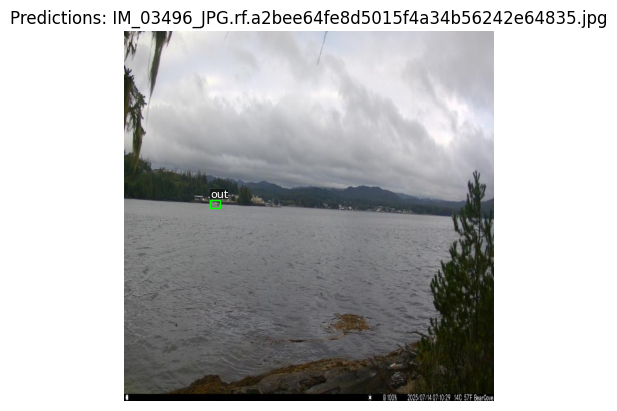

In [9]:
# Show predictions on a few random validation images

val_img_dir = 'img\\chokepoint v3\\valid\\images'
val_imgs = [os.path.join(val_img_dir, f) for f in os.listdir(val_img_dir) if f.endswith(('.jpg', '.png'))]
for img_path in random.sample(val_imgs, min(3, len(val_imgs))):
    results = model_trained(img_path)
    # Get predicted boxes and classes from results[0]
    pred_boxes = results[0].boxes.xyxy.cpu().numpy() if results[0].boxes is not None else []
    pred_classes = results[0].boxes.cls.cpu().numpy().astype(int) if results[0].boxes is not None else []
    # Plot image and predicted boxes using the same logic as plot_yolo_labels
    img = Image.open(img_path)
    plt.imshow(img)
    ax = plt.gca()
    class_names = ['in', 'out']
    for box, cls in zip(pred_boxes, pred_classes):
        x1, y1, x2, y2 = box
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='lime', linewidth=1)
        ax.add_patch(rect)
        ax.text(x1, y1 - 2, class_names[cls], color='white', fontsize=8, va='bottom', ha='left', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', pad=0))
    plt.axis('off')
    plt.title(f'Predictions: {os.path.basename(img_path)}')
    plt.show()

## 8. Run Inference on Sample Images

Use the trained model to predict boats in new images and visualize the results.


image 1/1 c:\Users\hp\Desktop\PSF\camera_fishing_effort\notebooks\img\chokepoint v3\test\images\IM_03859_JPG.rf.2f1cab1663061e92913a1cb746bf4506.jpg: 416x416 1 out, 304.1ms
Speed: 13.8ms preprocess, 304.1ms inference, 3.6ms postprocess per image at shape (1, 3, 416, 416)


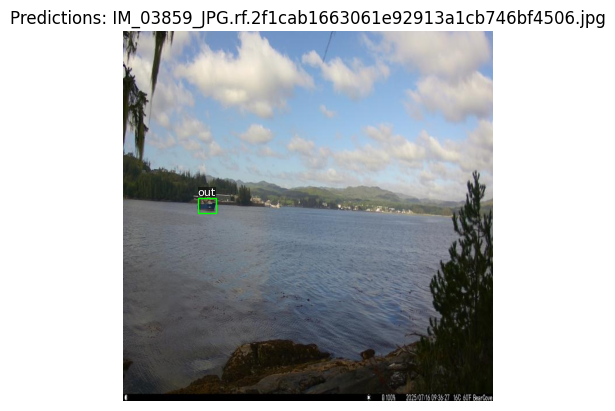


image 1/1 c:\Users\hp\Desktop\PSF\camera_fishing_effort\notebooks\img\chokepoint v3\test\images\IM_03509_JPG.rf.682f20275df43aef7f23d6c579eb1270.jpg: 416x416 1 in, 311.7ms
Speed: 4.8ms preprocess, 311.7ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)


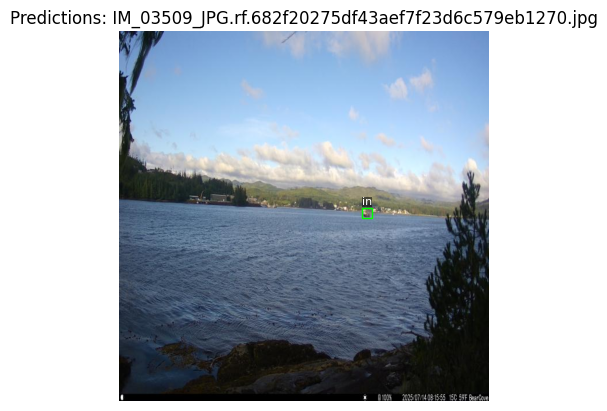


image 1/1 c:\Users\hp\Desktop\PSF\camera_fishing_effort\notebooks\img\chokepoint v3\test\images\IM_05665_JPG.rf.ba429ecd86c34202f59ed01dc40b54a2.jpg: 416x416 (no detections), 155.7ms
Speed: 3.3ms preprocess, 155.7ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)


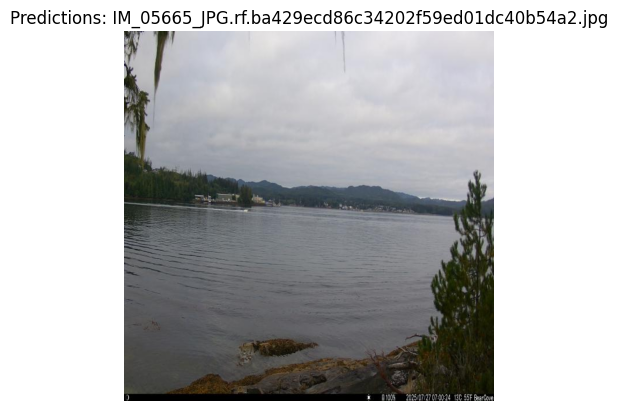

In [12]:
# Inference on new test images

test_img_dir = 'img\\chokepoint v3\\test\\images'  
test_imgs = [os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir) if f.endswith(('.jpg', '.png'))]
for img_path in random.sample(test_imgs, min(3, len(test_imgs))):
    results = model_trained(img_path)
    pred_boxes = results[0].boxes.xyxy.cpu().numpy() if results[0].boxes is not None else []
    pred_classes = results[0].boxes.cls.cpu().numpy().astype(int) if results[0].boxes is not None else []
    img = Image.open(img_path)
    plt.imshow(img)
    ax = plt.gca()
    class_names = ['in', 'out']
    for box, cls in zip(pred_boxes, pred_classes):
        x1, y1, x2, y2 = box
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='lime', linewidth=1)
        ax.add_patch(rect)
        ax.text(x1, y1 - 2, class_names[cls], color='white', fontsize=8, va='bottom', ha='left', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', pad=0))
    plt.axis('off')
    plt.title(f'Predictions: {os.path.basename(img_path)}')
    plt.show()